# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optimizers
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device : ", device)

Device :  cuda:0


# Data

In [2]:
DATA_PATH = ".mnist_digits"
# Getting Data
train_data = torchvision.datasets.MNIST(root=DATA_PATH,
                            train=True,
                            download=True)

class_names = train_data.classes

test_data = torchvision.datasets.MNIST(root=DATA_PATH,
                            train=False,
                            download=True)


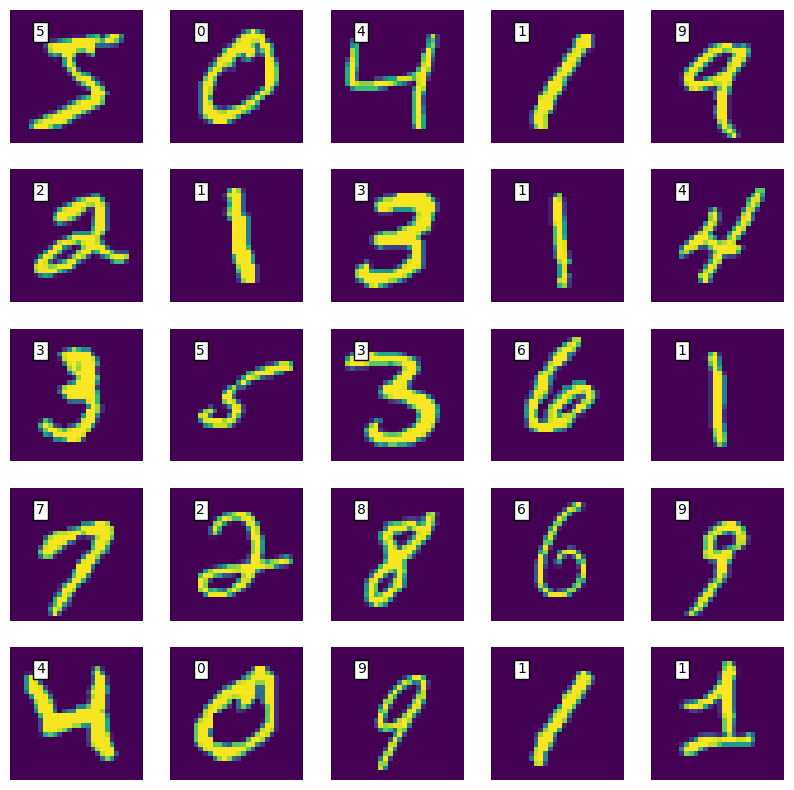

In [3]:
def plot_images(images, labels):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10,10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        # If using pytorch GPU
        # ax.imshow(images[i].view(28, 28).cpu().numpy())
        ax.imshow(images[i])
        ax.text(5, 5, labels[i], bbox={'facecolor': 'white', 'pad': 2})
        ax.axis('off')

N_IMAGES = 25
images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
labels = [label for image, label in [train_data[i] for i in range(N_IMAGES)]]
plot_images(images, labels)

In [4]:
mean = 0.1307
std = 0.3081

In [5]:
# Data Augmentation
IMAGE_SIZE = (28,28)
train_transforms = transforms.Compose([
    transforms.RandomRotation(5, fill=(0,)),
    transforms.RandomCrop(28, padding=2),
    transforms.Resize(IMAGE_SIZE),
    # Normalization
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

validation_transforms = transforms.Compose([
    transforms.ToTensor(),
    # Normalization
    transforms.Normalize(mean=[mean], std=[std])
])

test_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    # Normalization
    transforms.Normalize(mean=[mean], std=[std])
])

In [6]:
# Splitting data
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples],)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [7]:
train_data.transform = train_transforms
valid_data.dataset.transform = validation_transforms
test_data.transform = test_transforms

BATCH_SIZE = 512

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)
                                

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

# Convolutional Neural Network

In [8]:
class CNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=6,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        self.fc_1 = nn.Linear(16 * 4 * 4, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.fc_3(x)
        return x

In [9]:
OUTPUT_DIM = len(class_names)
INPUT_DIM = IMAGE_SIZE
LEARNING_RATE = 0.001
EPOCHS = 100
EPOCHS = 20
model = CNN(INPUT_DIM, OUTPUT_DIM).to(device)
optimizer = optimizers.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=256, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)


# Training

In [10]:
# Defining training and evaluation functions
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Training loop on train and val datasets
best_valid_loss = float('inf')

from tqdm.notebook import tqdm, trange
import time

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print("Model improved, saving...")
        print("New best validation loss : ", best_valid_loss)
        print("New best validation accuracy : ", valid_acc)
        torch.save(model.state_dict(), './model/cnn_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Model improved, saving...
New best validation loss :  0.2367771454155445
New best validation accuracy :  0.9308622082074484
Epoch: 01 | Epoch Time: 0m 13s
	Train Loss: 0.803 | Train Acc: 78.12%
	 Val. Loss: 0.237 |  Val. Acc: 93.09%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Model improved, saving...
New best validation loss :  0.13917162145177522
New best validation accuracy :  0.9596566458543142
Epoch: 02 | Epoch Time: 0m 12s
	Train Loss: 0.177 | Train Acc: 94.74%
	 Val. Loss: 0.139 |  Val. Acc: 95.97%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Model improved, saving...
New best validation loss :  0.11093555515011151
New best validation accuracy :  0.9666836510101954
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.118 | Train Acc: 96.44%
	 Val. Loss: 0.111 |  Val. Acc: 96.67%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Model improved, saving...
New best validation loss :  0.08855950956543286
New best validation accuracy :  0.974163552125295
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.094 | Train Acc: 97.15%
	 Val. Loss: 0.089 |  Val. Acc: 97.42%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Model improved, saving...
New best validation loss :  0.08290424725661676
New best validation accuracy :  0.9756920884052912
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.079 | Train Acc: 97.57%
	 Val. Loss: 0.083 |  Val. Acc: 97.57%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Model improved, saving...
New best validation loss :  0.0770806825409333
New best validation accuracy :  0.9772206197182337
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.068 | Train Acc: 97.94%
	 Val. Loss: 0.077 |  Val. Acc: 97.72%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Model improved, saving...
New best validation loss :  0.06499003898352385
New best validation accuracy :  0.9810631821552912
Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 0.060 | Train Acc: 98.16%
	 Val. Loss: 0.065 |  Val. Acc: 98.11%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Model improved, saving...
New best validation loss :  0.06152167326460282
New best validation accuracy :  0.9810277968645096
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.055 | Train Acc: 98.31%
	 Val. Loss: 0.062 |  Val. Acc: 98.10%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.049 | Train Acc: 98.49%
	 Val. Loss: 0.066 |  Val. Acc: 97.99%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Model improved, saving...
New best validation loss :  0.05347203649580479
New best validation accuracy :  0.9844811509052912
Epoch: 10 | Epoch Time: 0m 10s
	Train Loss: 0.048 | Train Acc: 98.50%
	 Val. Loss: 0.053 |  Val. Acc: 98.45%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 10s
	Train Loss: 0.040 | Train Acc: 98.76%
	 Val. Loss: 0.055 |  Val. Acc: 98.35%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Model improved, saving...
New best validation loss :  0.05207986291497946
New best validation accuracy :  0.9853586405515671
Epoch: 12 | Epoch Time: 0m 11s
	Train Loss: 0.038 | Train Acc: 98.85%
	 Val. Loss: 0.052 |  Val. Acc: 98.54%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 11s
	Train Loss: 0.034 | Train Acc: 98.92%
	 Val. Loss: 0.059 |  Val. Acc: 98.33%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 11s
	Train Loss: 0.031 | Train Acc: 99.00%
	 Val. Loss: 0.055 |  Val. Acc: 98.41%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Model improved, saving...
New best validation loss :  0.05115261720493436
New best validation accuracy :  0.9849694321552912
Epoch: 15 | Epoch Time: 0m 11s
	Train Loss: 0.030 | Train Acc: 99.03%
	 Val. Loss: 0.051 |  Val. Acc: 98.50%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 12s
	Train Loss: 0.027 | Train Acc: 99.15%
	 Val. Loss: 0.053 |  Val. Acc: 98.50%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 11s
	Train Loss: 0.025 | Train Acc: 99.23%
	 Val. Loss: 0.053 |  Val. Acc: 98.62%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 10s
	Train Loss: 0.022 | Train Acc: 99.28%
	 Val. Loss: 0.052 |  Val. Acc: 98.63%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 10s
	Train Loss: 0.019 | Train Acc: 99.40%
	 Val. Loss: 0.054 |  Val. Acc: 98.59%


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 10s
	Train Loss: 0.020 | Train Acc: 99.35%
	 Val. Loss: 0.068 |  Val. Acc: 98.18%


# Eval

In [12]:
# Evaluating model on test dataset
model.load_state_dict(torch.load('./model/cnn_model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Test Loss: 0.036 | Test Acc: 98.86%


tensor([7, 2, 1,  ..., 4, 5, 6])


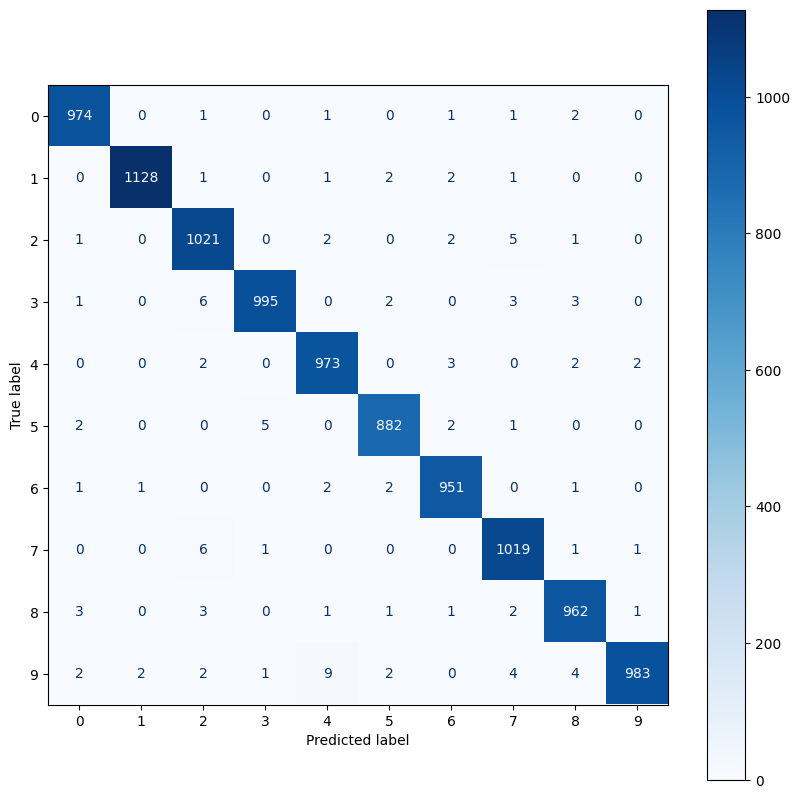

In [13]:
# Getting images their labels and probabilities
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)
print(pred_labels)

# Plotting confusion matrix
def plot_confusion_matrix(labels, pred_labels):
    from sklearn import metrics
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

plot_confusion_matrix(labels, pred_labels)